In [3]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../../../mathematical_models"))
from mathematical_models.f_on_f import FunctionOnFunctionModel
from mathematical_models.s_on_f import ScalarOnFunctionModel
from datetime import datetime

sys.path.append(os.path.abspath("../../../optimizers"))
from optimizers.cordex_continuous import CordexContinuous
from optimizers.nbdo import NBDO

sys.path.append(os.path.abspath("../../basis"))
from basis.bspline import BSplineBasis
from basis.polynomial import PolynomialBasis
from basis.fourier import FourierBasis
from basis.basis import plot_design
from basis.basis import Basis

from J.jmatrix import JMatrix

In [4]:
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.linalg import block_diag

def compute_DER_MAT(basis_pair, const=True):
    R_blocks = []

    for _, b_base in basis_pair:
        num_basis = b_base.num_basis()

        def second_derivative(i, t):
            return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)

        R = np.zeros((num_basis, num_basis))
        for i in range(num_basis):
            for j in range(num_basis):
                integrand = lambda t: second_derivative(i, t) * second_derivative(j, t)
                R[i, j], _ = quad(integrand, 0, 1)

        R_blocks.append(R)

    # Create block diagonal matrix from all R_blocks
    R_combined = block_diag(*R_blocks)
    if const:
        # Expand the final matrix to include the leading 1
        final_size = R_combined.shape[0] + 1
        R_with_one = np.zeros((final_size, final_size))
        R_with_one[0, 0] = 1
        R_with_one[1:, 1:] = R_combined

        return R_with_one
    else:
        return R_combined

In [5]:
from scipy.integrate import quad
from scipy.misc import derivative

def compute_average_variation(design_matrix, basis, dx=1e-4):
    if design_matrix.size == 0:
        return 0.0

    N = design_matrix.shape[0]  # number of designs
    K = design_matrix.shape[1]  # number of basis functions (should match basis.num_basis())

    total_tv = 0.0

    for n in range(N):
        coeffs = design_matrix[n, :]

        # Define the function f_n(t) = sum_i coeffs[i] * basis_i(t)
        def f_n(t):
            val = 0.0
            for k in range(K):
                val += coeffs[k] * basis.evaluate_basis_function(k, t)
            return val

        def integrand(t):
            return abs(
                derivative(f_n, t, dx=dx, n=1)  # first derivative
            )

        tv, _ = quad(integrand, 0, 1)
        total_tv += tv

    avg_tv = total_tv / N
    return avg_tv

In [6]:
def compute_relative_efficiency(model, design, criterion, lambda_s_2, lambda_t_2):
    N = design.shape[0]
    ones = np.ones((N,1))
    Gamma = np.hstack((ones, design))
    Z = Gamma @ model.J
    denom1 = np.kron(model.I_Kb_t, Z.T @ Z)
    denom2 = lambda_s_2 * np.kron(model.I_Kb_t, model.R)
    denom3 = lambda_t_2 * np.kron(model.S, model.J_HH)
    denominator = np.linalg.det(denom1 + denom2 + denom3)
    criterion_new = np.exp(np.log(1) - np.log(denominator))
    eff = criterion / criterion_new
    return eff, criterion, criterion_new

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


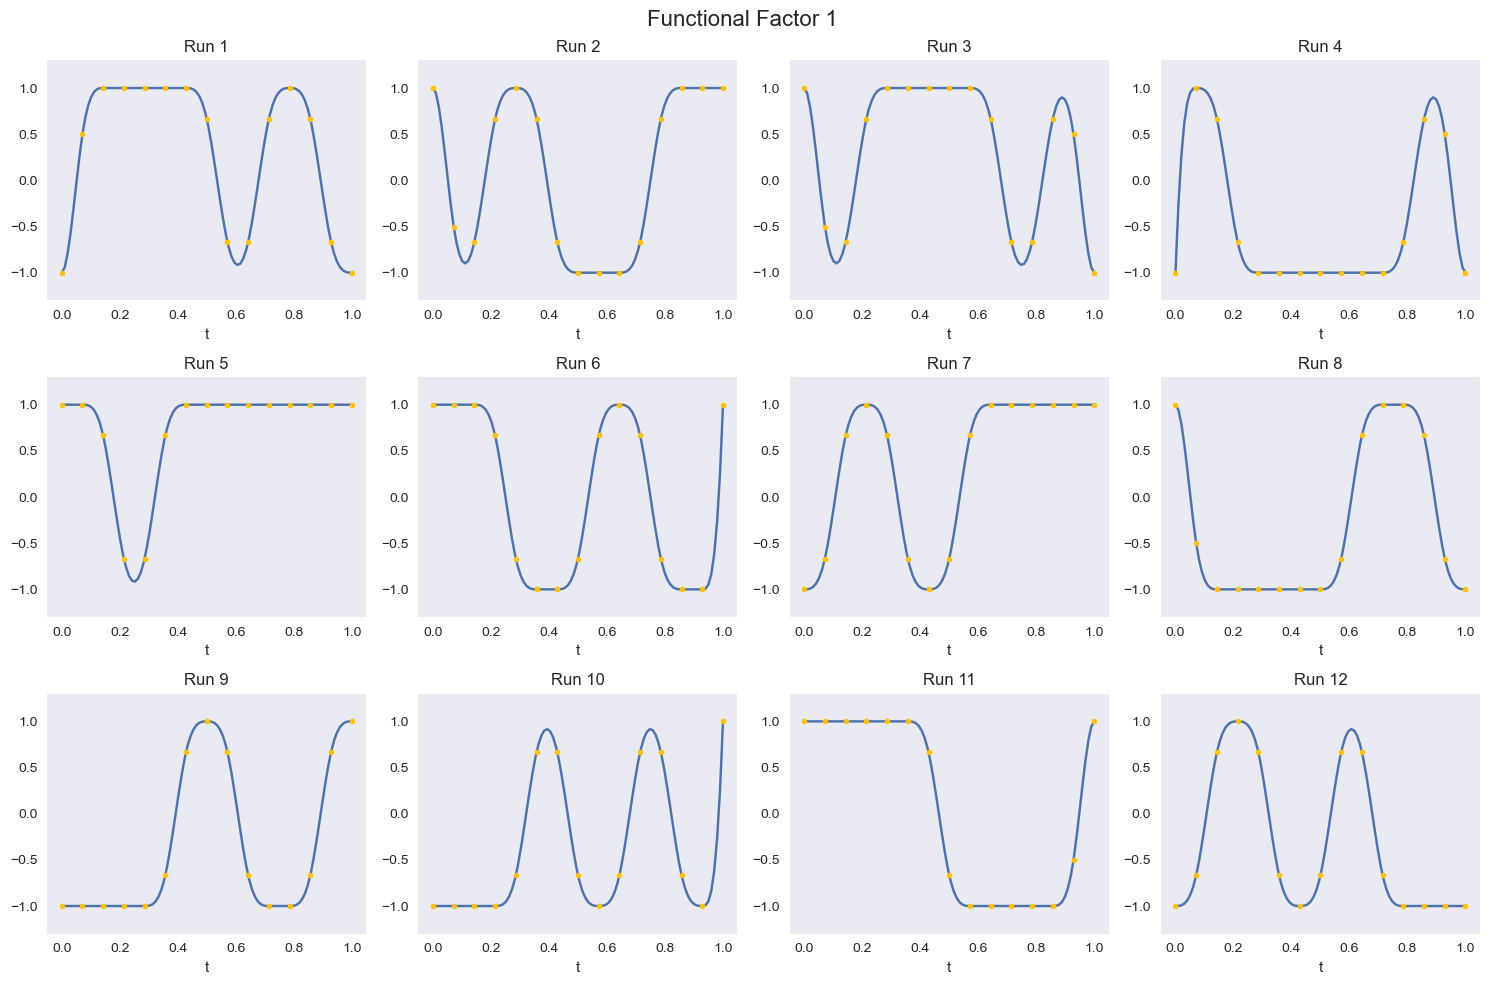

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.0, lambda_t: 0.0, objective: 1415334858621.2827, average total variance 7.015984644603812


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


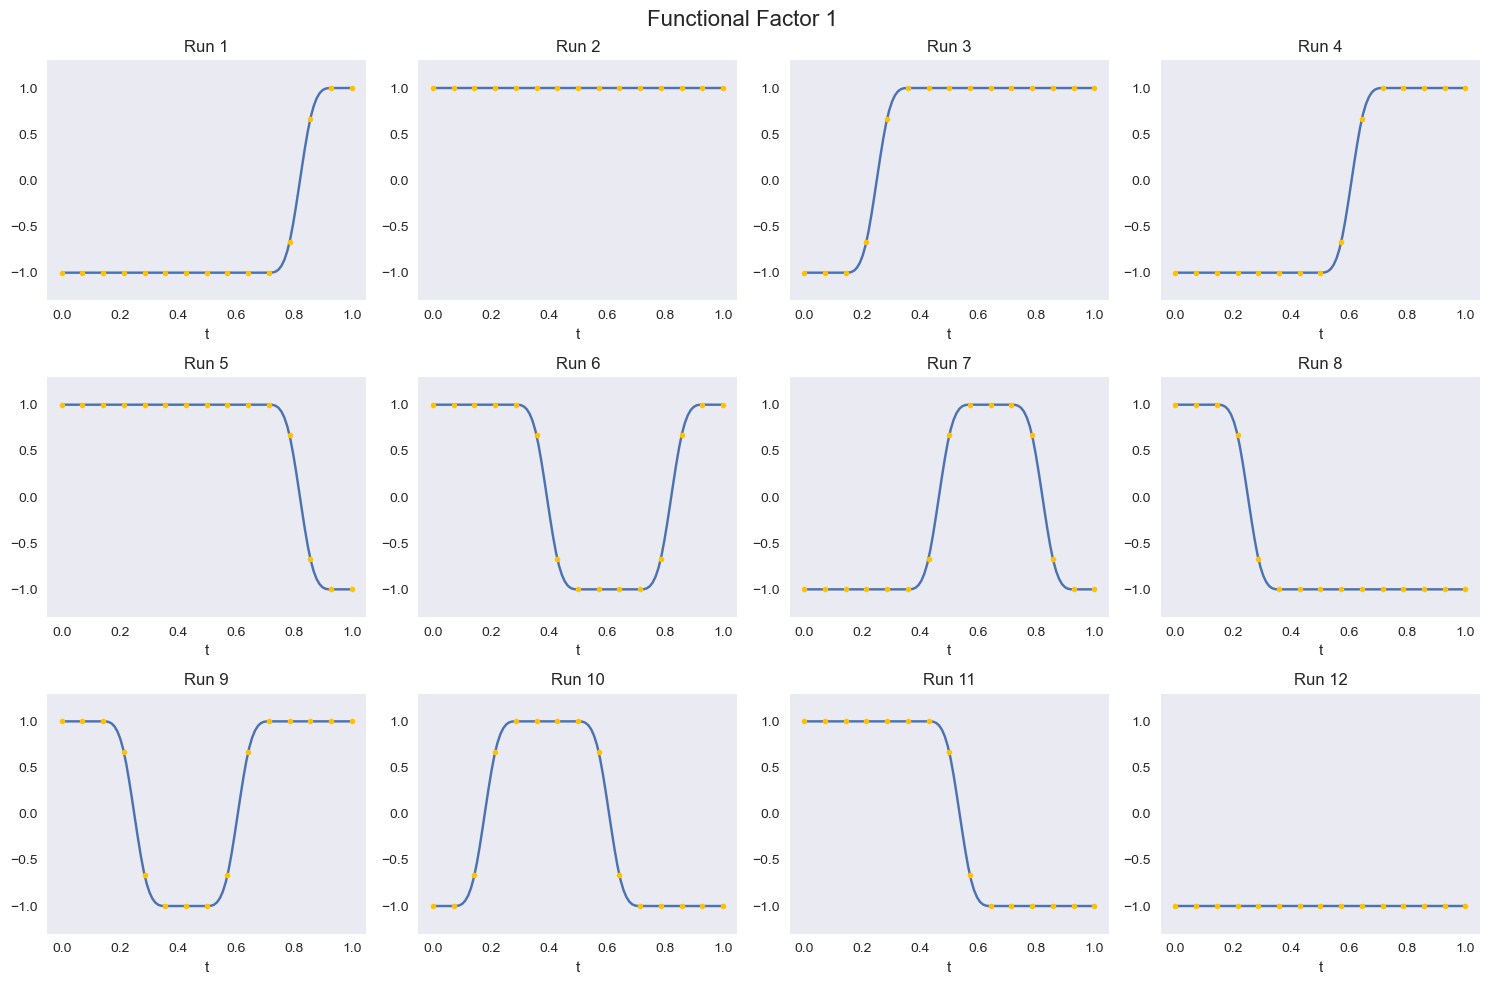

lambda_s: 0.000283061566304706, lambda_t: 4.010150373503106e-05, objective: 4840740561087358.0, average total variance 2.3333333333848514


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative


In [6]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=5) # theta
lambdas = [0, 1]

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_60142/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_60142/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


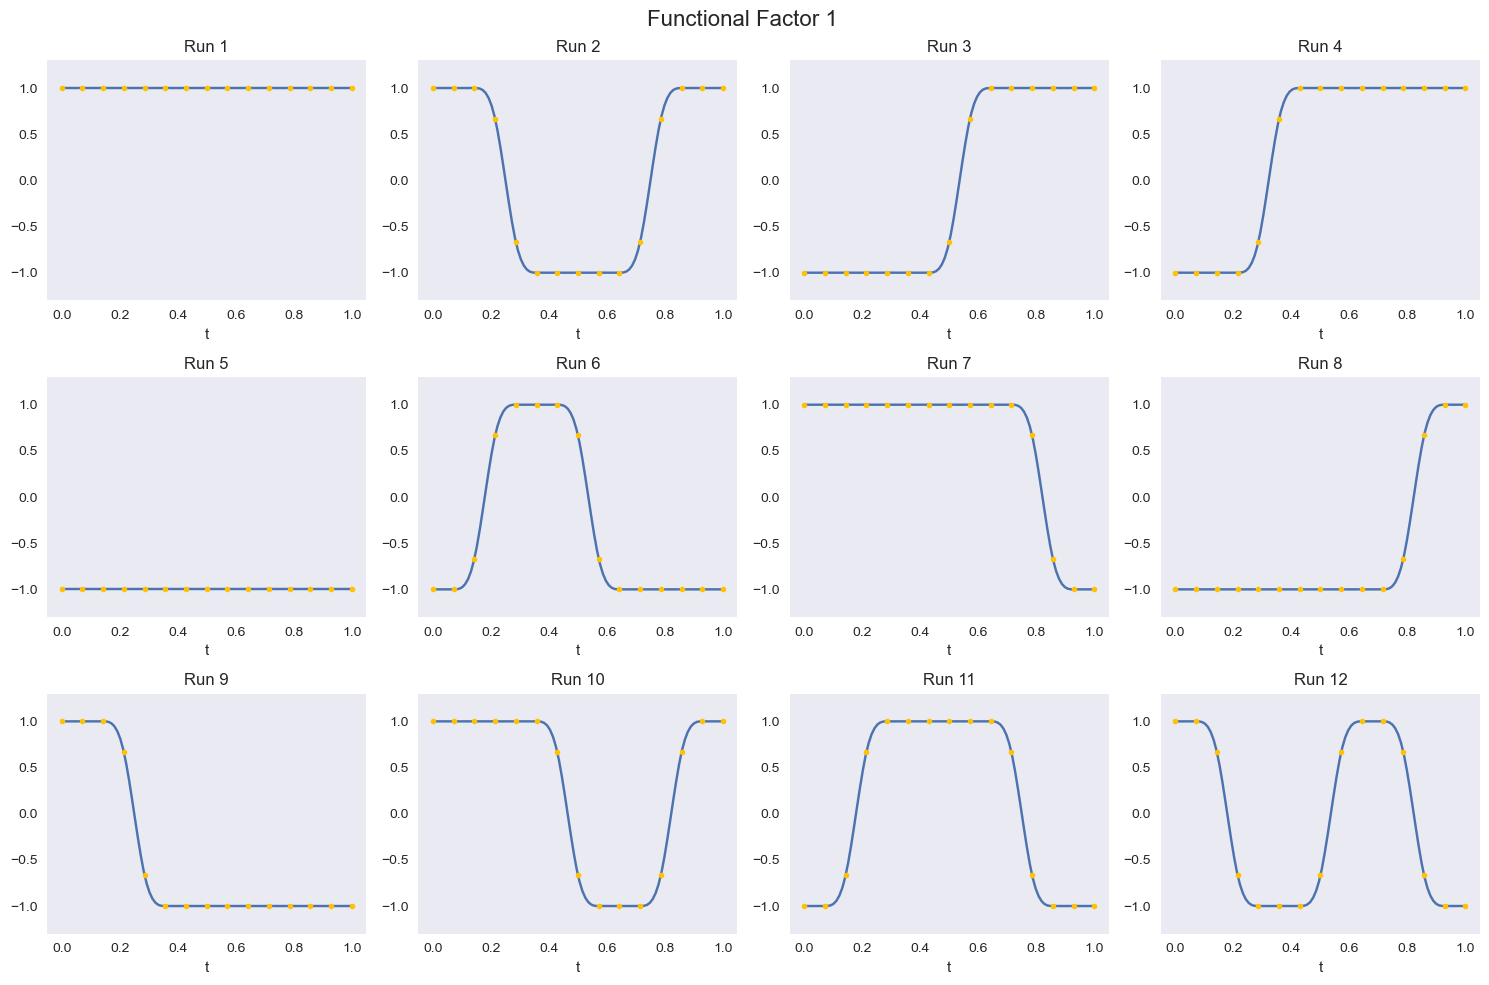

lambda_s: 0.00014294609098387654, lambda_t: 2.0251259386190684e-05, objective: 5.1018515090531464e+22, average total variance 2.666666666397212


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_60142/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_60142/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [7]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=5) # theta

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

lambda_s = 0.5050/np.max(np.abs(R))
lambda_t = 0.5050/np.max(np.abs(np.kron(S, J_HH)))
model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
optimizer = CordexContinuous(model=model, runs=12)
best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
plot_design(best_design, [x_base], 12,
            sub_x=3, sub_y=4, colour="#FFC100")
avg_tv = compute_average_variation(best_design, basis=x_base)
print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
100%|██████████| 10/10 [00:00<00:00, 10.75it/s]


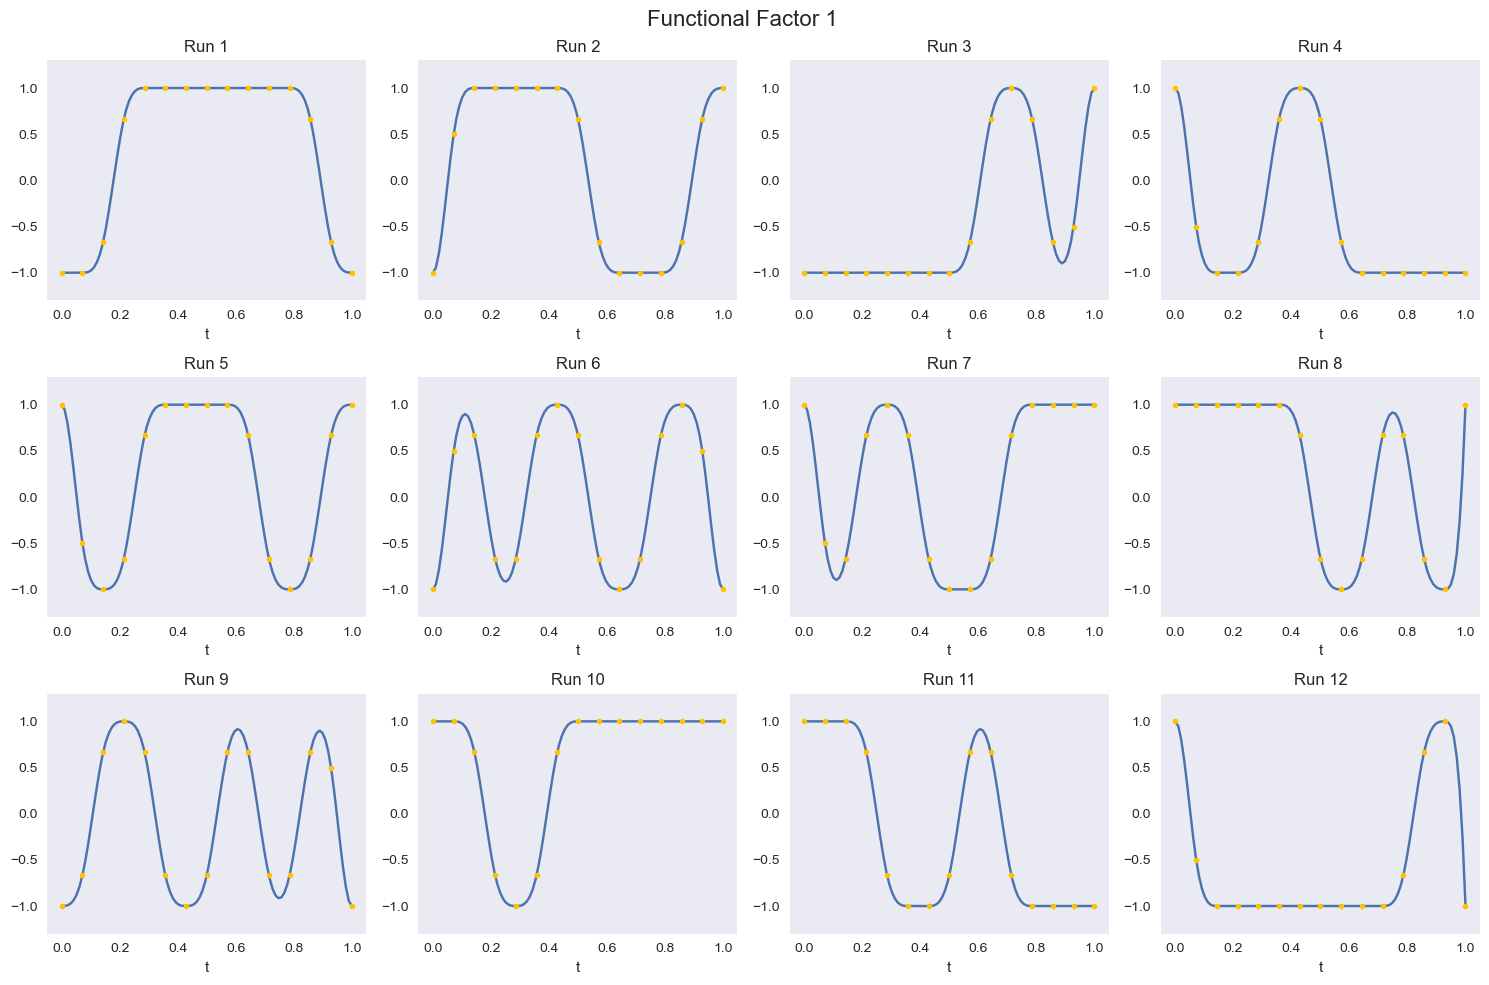

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 0.0, lambda_t: 0.0, objective: 1411141207985.6997, average total variance 7.029872826381994


100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


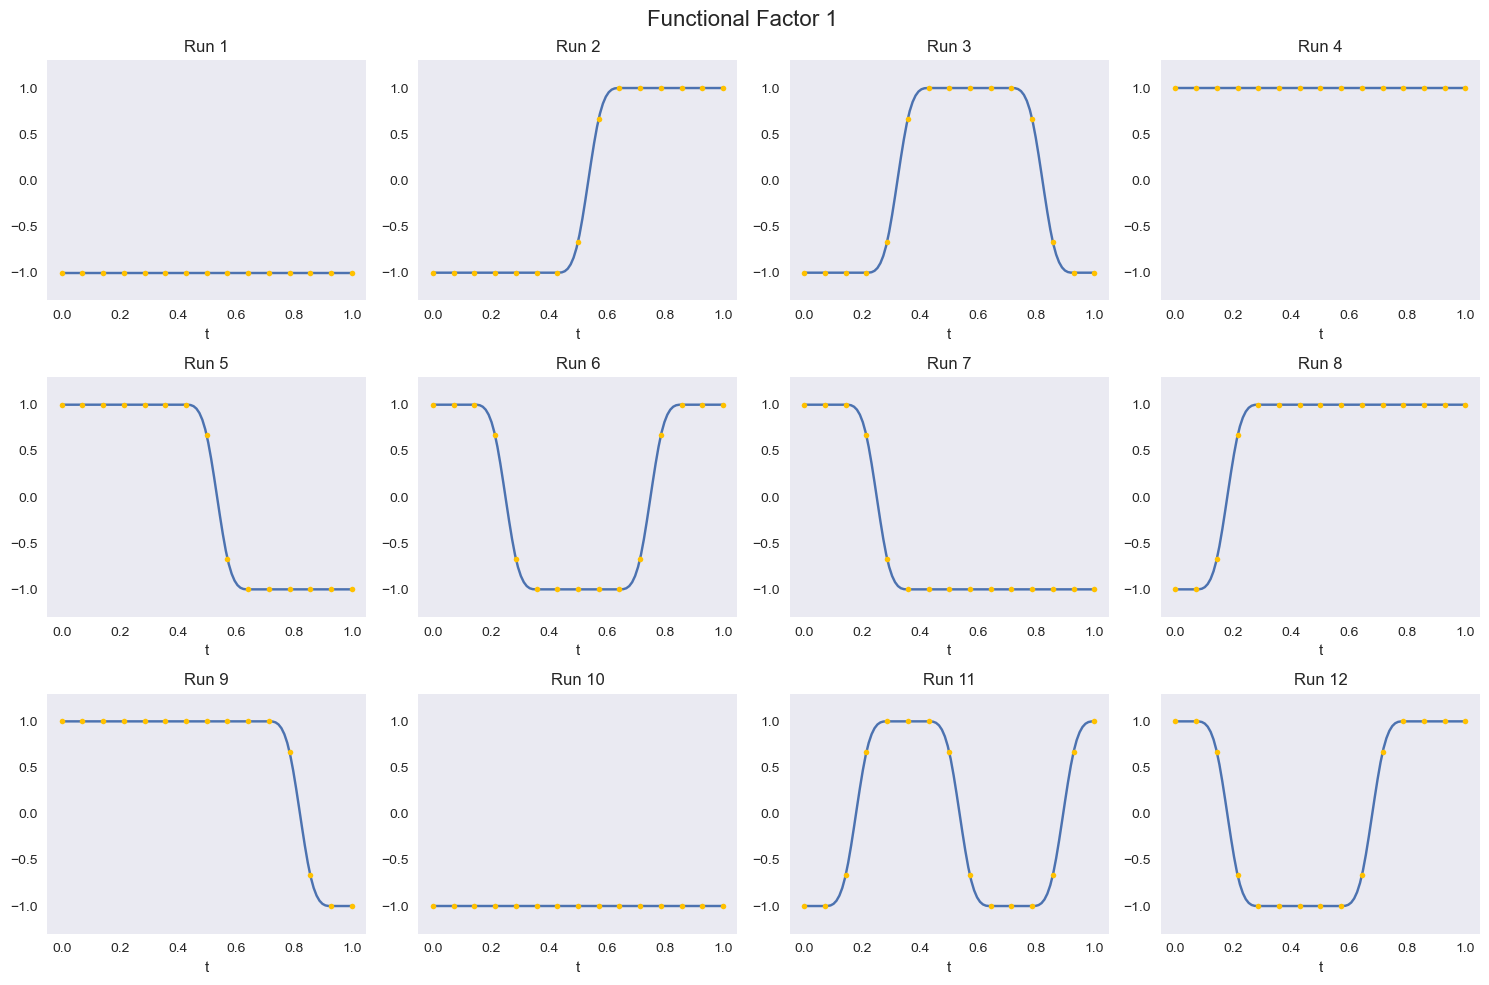

lambda_s: 0.000283061566304706, lambda_t: 4.010150373503106e-05, objective: 1.8425196524452118e+17, average total variance 2.3333333338703293


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [7]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=5) # theta
lambdas = [0, 1]

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=0, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")

In [2]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=4, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=5) # theta
lambdas = np.linspace(0.01, 1, 5)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

results_lambda_0 = []
for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=0, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=12)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 12,
                sub_x=3, sub_y=4, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")

    results_lambda_0.append({
        "model": model,
        "lambda_": lambda_,
        "lambda_s": lambda_s,
        "lambda_t": lambda_t,
        "best_design": best_design,
        "best_objective": best_objective,
        "average_total_variance": avg_tv
    })

NameError: name 'compute_DER_MAT' is not defined

In [9]:
for idx, result in enumerate(results_lambda_0, 1):
    print(f"\n--- Result {idx} ---")
    print(f"Lambda: {result['lambda_']:.4f}")
    print(f"Lambda_s: {result['lambda_s']:.4f}")
    print(f"Lambda_t: {result['lambda_t']:.4f}")
    print(f"Best Objective: {result['best_objective']:.4f}")
    print(f"Average Total Variance: {result['average_total_variance']:.4f}")


--- Result 1 ---
Lambda: 0.0100
Lambda_s: 0.0000
Lambda_t: 0.0000
Best Objective: 69455164894413402387479683923106361522299275837440.0000
Average Total Variance: 4.6250

--- Result 2 ---
Lambda: 0.2575
Lambda_s: 0.0001
Lambda_t: 0.0000
Best Objective: 529890853576089077464715755520.0000
Average Total Variance: 3.0000

--- Result 3 ---
Lambda: 0.5050
Lambda_s: 0.0001
Lambda_t: 0.0000
Best Objective: 469067929075170876063744.0000
Average Total Variance: 2.6667

--- Result 4 ---
Lambda: 0.7525
Lambda_s: 0.0002
Lambda_t: 0.0000
Best Objective: 119635846850703228928.0000
Average Total Variance: 2.3333

--- Result 5 ---
Lambda: 1.0000
Lambda_s: 0.0003
Lambda_t: 0.0000
Best Objective: 231906152565624672.0000
Average Total Variance: 2.5000


In [10]:
import pandas as pd
results_lambda_0_pd = pd.DataFrame(results_lambda_0)
results_lambda_0_pd

,model,lambda_,lambda_s,lambda_t,best_design,best_objective,average_total_variance
0,<mathematical_models.f_on_f.FunctionOnFunction...,0.0100,0.000003,4.010150e-07,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",6.945516e+49,4.624999
1,<mathematical_models.f_on_f.FunctionOnFunction...,0.2575,0.000073,1.032614e-05,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0...",5.298909e+29,3.000000
2,<mathematical_models.f_on_f.FunctionOnFunction...,0.5050,0.000143,2.025126e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",4.690679e+23,2.666667
3,<mathematical_models.f_on_f.FunctionOnFunction...,0.7525,0.000213,3.017638e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1....",1.196358e+20,2.333333
4,<mathematical_models.f_on_f.FunctionOnFunction...,1.0000,0.000283,4.010150e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2.319062e+17,2.500000


In [11]:
# Select the middle design (reference)
reference_result = results_lambda_0[2]  # index 2 corresponds to lambda ~ 0.5050
reference_model = reference_result['model']
reference_design = reference_result['best_design']
reference_criterion = reference_result['best_objective']
reference_lambda_s = reference_result['lambda_s']
reference_lambda_t = reference_result['lambda_t']

# Calculate efficiency of each design relative to the middle one
print("\nRelative Efficiency based on design with lambda ~ 0.5050:\n")

for idx, result in enumerate(results_lambda_0, 1):
    eff, crit_ref, crit_new = compute_relative_efficiency(
        model=reference_model,
        design=result['best_design'],
        criterion=reference_criterion,
        lambda_s_2=reference_lambda_s,
        lambda_t_2=0
    )
    print(f"Design {idx} (Lambda={result['lambda_']:.4f}):")
    print(f"  Efficiency: {eff * 100:.2f}%")
    print(f"  Criterion (reference): {crit_ref:.6f}")
    print(f"  Criterion (current): {crit_new:.6f}\n")


Relative Efficiency based on design with lambda ~ 0.5050:

Design 1 (Lambda=0.0100):
  Efficiency: 1.75%
  Criterion (reference): 469067929075170876063744.000000
  Criterion (current): 26741399958448200191311872.000000

Design 2 (Lambda=0.2575):
  Efficiency: 68.23%
  Criterion (reference): 469067929075170876063744.000000
  Criterion (current): 687470908215885977092096.000000

Design 3 (Lambda=0.5050):
  Efficiency: 100.00%
  Criterion (reference): 469067929075170876063744.000000
  Criterion (current): 469067929075170876063744.000000

Design 4 (Lambda=0.7525):
  Efficiency: 59.82%
  Criterion (reference): 469067929075170876063744.000000
  Criterion (current): 784130248637873995644928.000000

Design 5 (Lambda=1.0000):
  Efficiency: 54.92%
  Criterion (reference): 469067929075170876063744.000000
  Criterion (current): 854106285245515729731584.000000



In [12]:
results_lambda_0_pd

,model,lambda_,lambda_s,lambda_t,best_design,best_objective,average_total_variance
0,<mathematical_models.f_on_f.FunctionOnFunction...,0.0100,0.000003,4.010150e-07,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",6.945516e+49,4.624999
1,<mathematical_models.f_on_f.FunctionOnFunction...,0.2575,0.000073,1.032614e-05,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0...",5.298909e+29,3.000000
2,<mathematical_models.f_on_f.FunctionOnFunction...,0.5050,0.000143,2.025126e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",4.690679e+23,2.666667
3,<mathematical_models.f_on_f.FunctionOnFunction...,0.7525,0.000213,3.017638e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1....",1.196358e+20,2.333333
4,<mathematical_models.f_on_f.FunctionOnFunction...,1.0000,0.000283,4.010150e-05,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2.319062e+17,2.500000


---

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: b_base.evaluate_basis_function(i, x), t, dx=1e-4, n=2)
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1942600051.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R[i, j], _ = quad(integrand, 0, 1)
  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


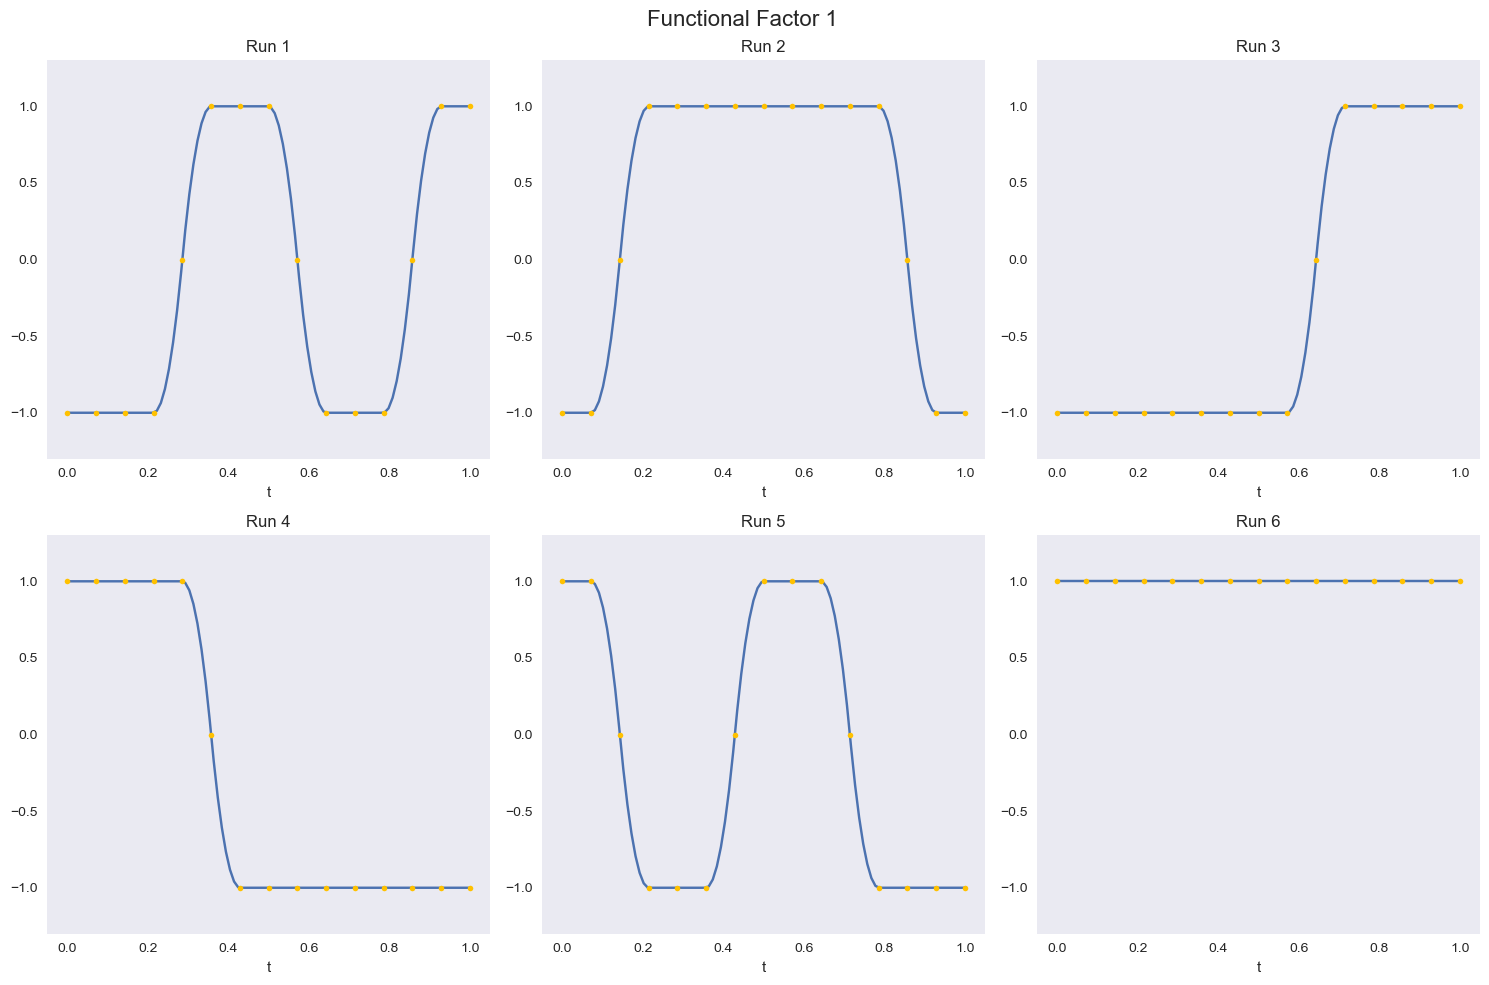

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 8.341273071333672e-07, lambda_t: 1.0265999140137161e-08, objective: 6.976493267803958e+206, average total variance 3.3333332092727237


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


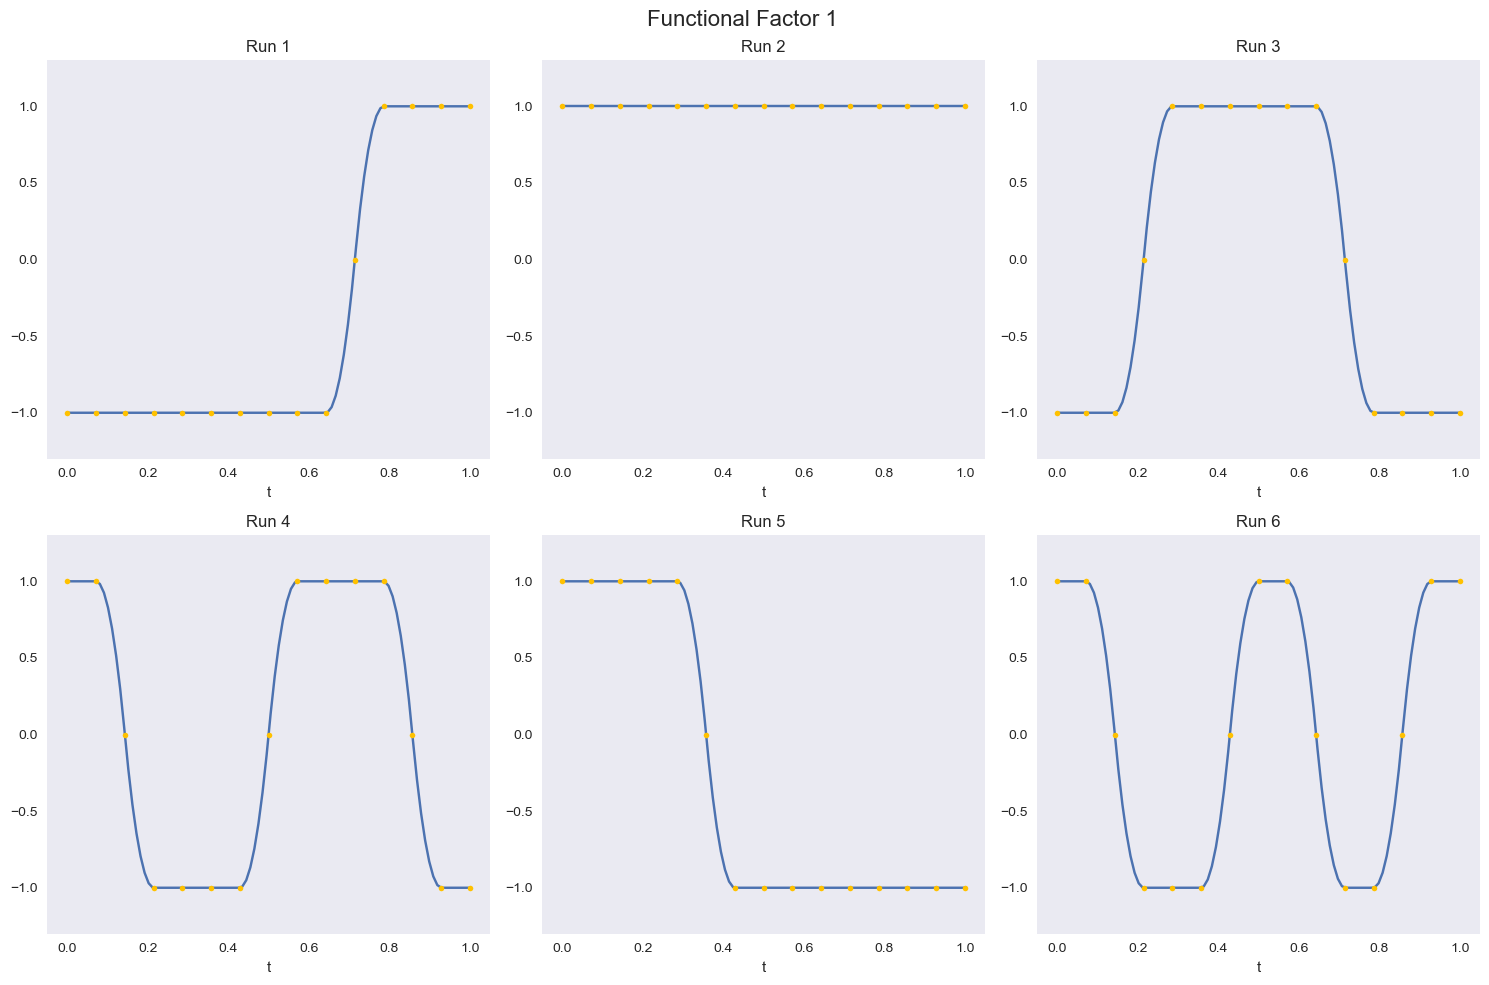

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 2.1478778158684204e-05, lambda_t: 2.643494778585319e-07, objective: 1.0727159933795418e+133, average total variance 3.6666671394658734


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


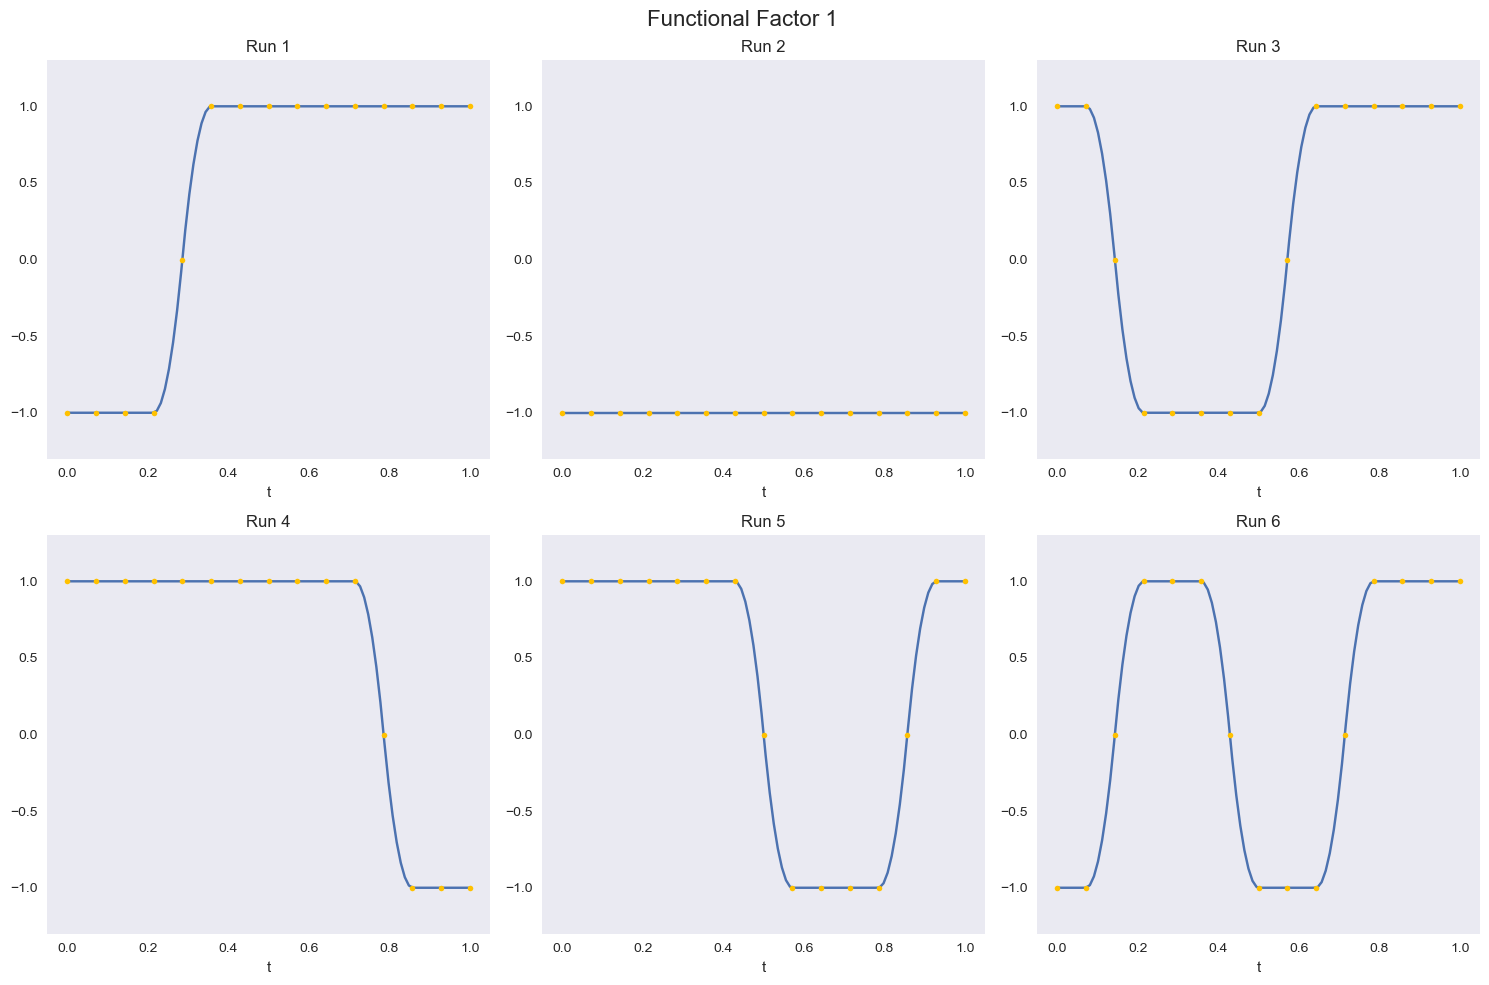

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 4.212342901023504e-05, lambda_t: 5.184329565769266e-07, objective: 3.101996633178995e+115, average total variance 3.0000000472734385


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


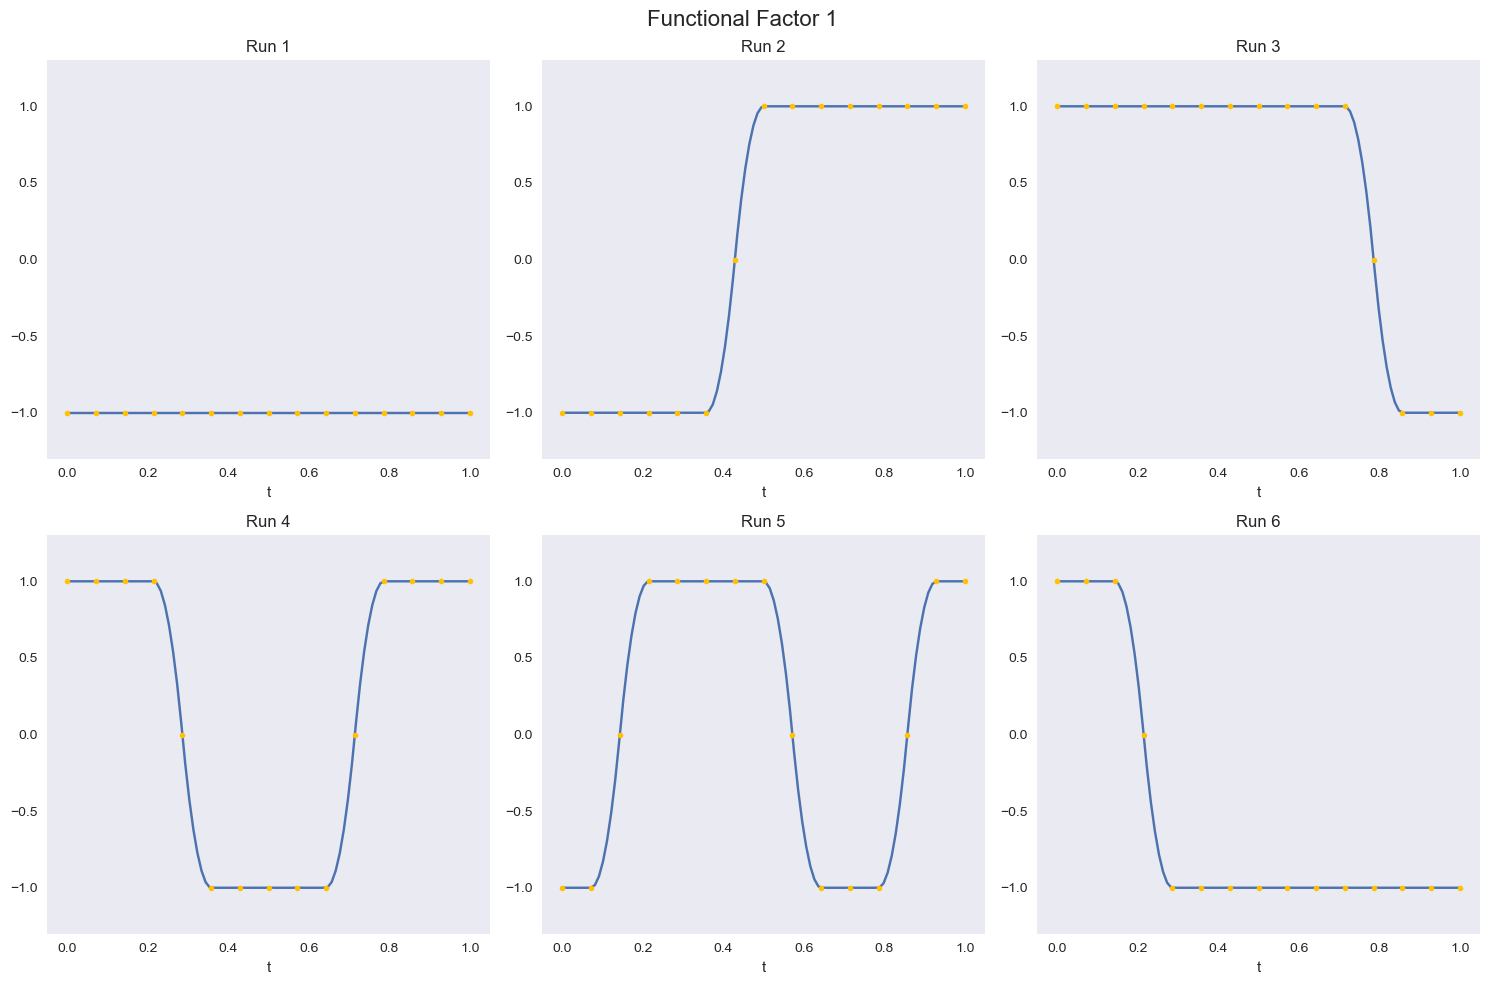

/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


lambda_s: 6.276807986178588e-05, lambda_t: 7.725164352953212e-07, objective: 2.4719668402506524e+104, average total variance 2.666665352399885


  0%|          | 0/100 [00:00<?, ?it/s]/Users/thodorisladas/Documents/code/system_optidex/mathematical_models/f_on_f.py:63: RuntimeWarning: invalid value encountered in scalar power
  nominator = np.linalg.det(Z.T @ Z)**((self.Kb_t + 1)/2)
100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


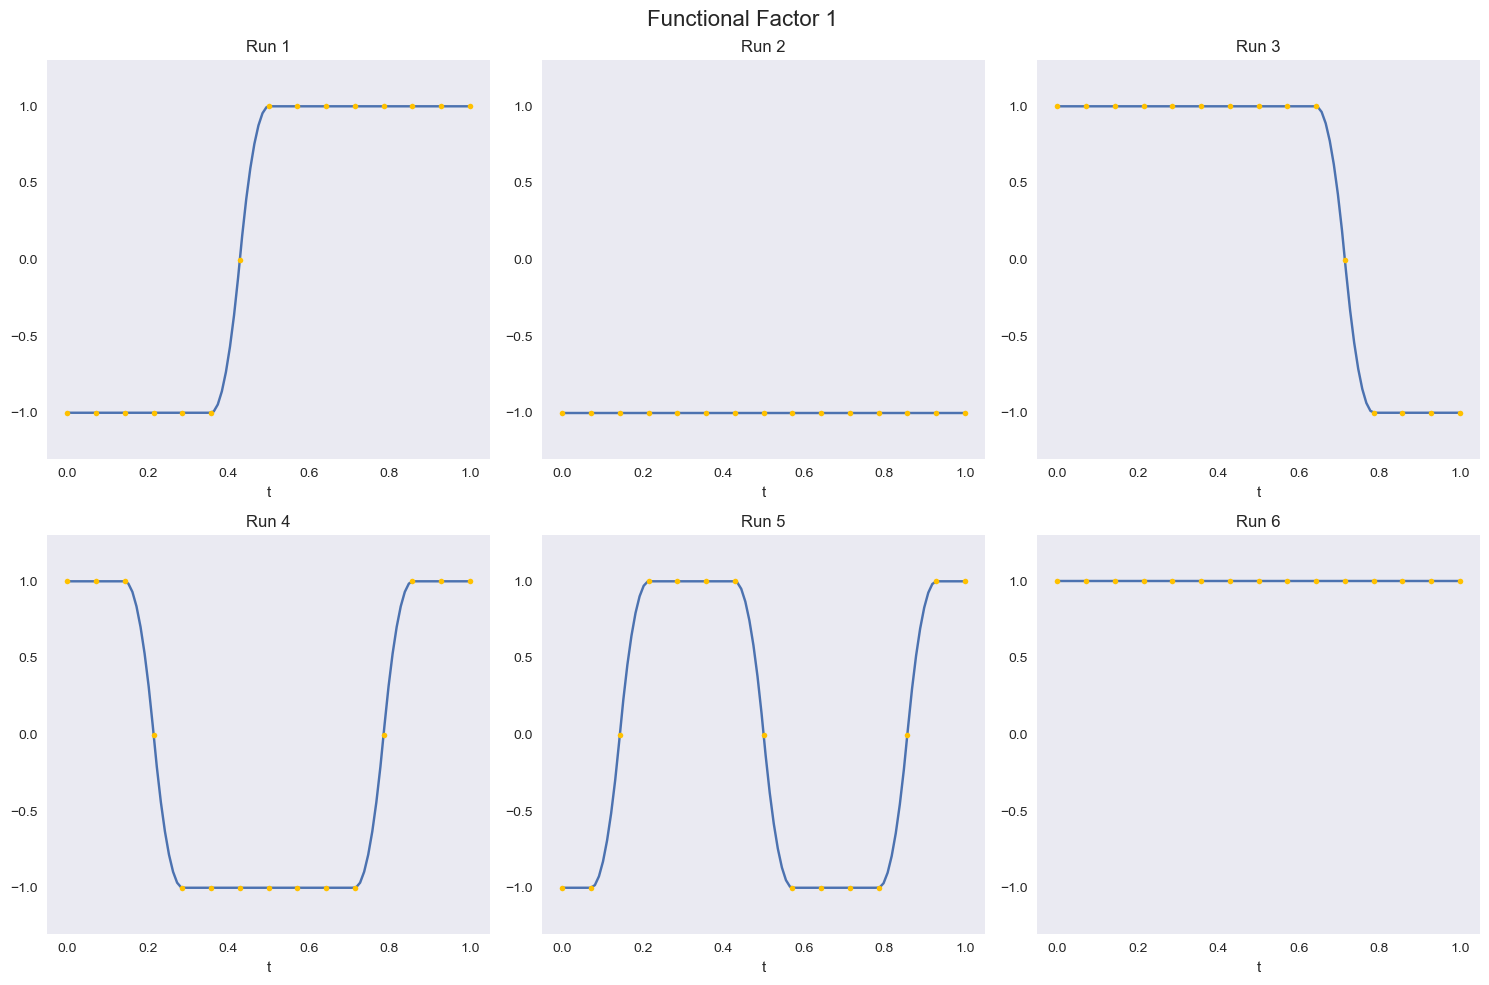

lambda_s: 8.341273071333672e-05, lambda_t: 1.026599914013716e-06, objective: 1.9911940612394775e+96, average total variance 2.3333332541917486


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  derivative(f_n, t, dx=dx, n=1)  # first derivative
/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_4924/1582371664.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tv, _ = quad(integrand, 0, 1)


In [13]:
x_base = BSplineBasis(degree=2, total_knots_num=15) # C
bs_base = BSplineBasis(degree=6, total_knots_num=5) # H
bt_base = FourierBasis(num_basis_functions=10) # theta
lambdas = np.linspace(0.01, 1, 5)

bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

results = []
for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=6)
    best_design, best_objective = optimizer.optimize(epochs=100, refinement_epochs=10)
    plot_design(best_design, [x_base], 6,
                sub_x=2, sub_y=3, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")

    results.append({
        "model": model,
        "lambda_": lambda_,
        "lambda_s": lambda_s,
        "lambda_t": lambda_t,
        "best_design": best_design,
        "best_objective": best_objective,
        "average_total_variance": avg_tv
    })

In [23]:
results_lambda_pd = pd.DataFrame(results)
results_lambda_pd

,model,lambda_,lambda_s,lambda_t,best_design,best_objective,average_total_variance
0,<mathematical_models.f_on_f.FunctionOnFunction...,0.0100,8.341273e-07,1.026600e-08,"[[-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0,...",6.976493e+206,3.333333
1,<mathematical_models.f_on_f.FunctionOnFunction...,0.2575,2.147878e-05,2.643495e-07,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",1.072716e+133,3.666667
2,<mathematical_models.f_on_f.FunctionOnFunction...,0.5050,4.212343e-05,5.184330e-07,"[[-1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0,...",3.101997e+115,3.000000
3,<mathematical_models.f_on_f.FunctionOnFunction...,0.7525,6.276808e-05,7.725164e-07,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",2.471967e+104,2.666665
4,<mathematical_models.f_on_f.FunctionOnFunction...,1.0000,8.341273e-05,1.026600e-06,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1....",1.991194e+96,2.333333


In [32]:
# Select the middle design (reference)
reference_result = results[2]  # index 2 corresponds to lambda ~ 0.5050
reference_model = reference_result['model']
reference_design = reference_result['best_design']
reference_criterion = reference_result['best_objective']
reference_lambda_s = reference_result['lambda_s']
reference_lambda_t = reference_result['lambda_t']

# Calculate efficiency of each design relative to the middle one
print("\nRelative Efficiency based on design with lambda ~ 0.5050:\n")

for idx, result in enumerate(results, 1):
    eff, crit_ref, crit_new = compute_relative_efficiency(
        model=reference_model,
        design=result['best_design'],
        criterion=reference_criterion,
        lambda_s_2=reference_lambda_s,
        lambda_t_2=reference_lambda_t
    )
    print(f"Design {idx} (Lambda={result['lambda_']:.4f}):")
    print(f" lambda_s :{result['lambda_s']}")
    print(f" lambda_t :{result['lambda_t']}")
    print(f"  Efficiency: {eff * 100:.2f}%")
    print(f"  Criterion (reference): {crit_ref:.6f}")
    print(f"  Criterion (current): {crit_new:.6f}\n")
    print(f"  Average Total Variance: {result['average_total_variance']:.2f}\n")


Relative Efficiency based on design with lambda ~ 0.5050:

Design 1 (Lambda=0.0100):
 lambda_s :8.341273071333672e-07
 lambda_t :1.0265999140137161e-08
  Efficiency: 65.04%
  Criterion (reference): 31019966331789949339309717388719287184667622790644715735657780766480473837983410641254284728744506106915339959795712.000000
  Criterion (current): 47693832344139922645266820055696805091738325194319623309524887332176143767912667490991886367163873644405377967587328.000000

  Average Total Variance: 3.33

Design 2 (Lambda=0.2575):
 lambda_s :2.1478778158684204e-05
 lambda_t :2.643494778585319e-07
  Efficiency: 51.90%
  Criterion (reference): 31019966331789949339309717388719287184667622790644715735657780766480473837983410641254284728744506106915339959795712.000000
  Criterion (current): 59766026408612740294350971402693482679609508301728656958946171365042721434120855466104263510189884815009444442144768.000000

  Average Total Variance: 3.67

Design 3 (Lambda=0.5050):
 lambda_s :4.212342901023504

---

In [ ]:
x_base = BSplineBasis(degree=3, total_knots_num=15) # C
bs_base = BSplineBasis(degree=12, total_knots_num=15) # H
bt_base = FourierBasis(num_basis_functions=50) # theta


bases_pairs = [(x_base, bs_base)]
jch_pairs = [(x_base, bs_base)]
jhh_pairs = [(bs_base, bs_base)]
j_thetatheta = [(bt_base, bt_base)]
J_CH = JMatrix(jch_pairs).compute()
J_HH = JMatrix(jhh_pairs).compute()
J_HH = np.pad(J_HH, ((1,0),(1,0)))
J_HH[0,0] = 1
J_thetatheta = JMatrix(j_thetatheta).compute()
R = compute_DER_MAT(jhh_pairs, const=True)
S = compute_DER_MAT(j_thetatheta, const=False)

In [ ]:
lambdas = np.linspace(100,100,1)
for lambda_ in lambdas:
    lambda_s = lambda_/np.max(np.abs(R))
    lambda_t = lambda_/np.max(np.abs(np.kron(S, J_HH)))
    model = FunctionOnFunctionModel(bases_pairs=bases_pairs, Sigma_decay=np.inf, const=True, lambda_s=lambda_s, lambda_t=lambda_t, R=R, S=S, J_HH=J_HH, Kb_t=bt_base.num_basis())
    optimizer = CordexContinuous(model=model, runs=6)
    best_design, best_objective = optimizer.optimize(epochs=1_000, refinement_epochs=100)
    plot_design(best_design, [x_base], 6,
                sub_x=3, sub_y=2, colour="#FFC100")
    avg_tv = compute_average_variation(best_design, basis=x_base)
    print(f"lambda_s: {lambda_s}, lambda_t: {lambda_t}, objective: {best_objective}, average total variance {avg_tv}")